In [1]:
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric import explain
from torch_geometric.data import Data

from torch_geometric.explain import unfaithfulness
from yfiles_jupyter_graphs import GraphWidget

from model import get_model
from data import get_data

/home/pasquale/miniconda3/envs/gnnleak/lib/python3.12/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/pasquale/miniconda3/envs/gnnleak/lib/python3.12/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "


In [2]:
data_path = "data/fuzzified_data_W24_S1_STRIDE12old.pt"

class FakeLogger:
    def info(self, msg):
        print(msg)

data = get_data(data_path, logger=FakeLogger(), edges_directed=False)

x_train: tensor[1167999, 33] n=38543967 (0.1Gb) x∈[3.345e-06, 1.000] μ=0.333 σ=0.333
x_val: tensor[146000, 33] n=4818000 (18Mb) x∈[4.342e-05, 0.999] μ=0.333 σ=0.327
x_test: tensor[146000, 33] n=4818000 (18Mb) x∈[3.090e-06, 1.000] μ=0.333 σ=0.333
----
No edge features


100%|██████████| 1167999/1167999 [00:17<00:00, 66506.70it/s]


Train data created


100%|██████████| 146000/146000 [00:01<00:00, 93265.45it/s]


Val data created


100%|██████████| 146000/146000 [00:02<00:00, 56351.29it/s]

Test data created


In [3]:
train_data, val_data, (test_data, test_labels), (num_nodes, num_edges) = data

In [4]:
node_dim = train_data[0].x.shape[1]
edge_dim = None

In [5]:
model_params = {
  "name": "GNNLeakDetector",
  "use_edges": False,
  "num_layers": 4,
  "hidden_size": 64,
  "gnn_layer": "GENConv",
}

model = get_model(**model_params, node_in=node_dim, edge_in=edge_dim)

In [6]:
model

GNNModel(
  (node_encoder): Linear(in_features=3, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x GENConv(64, 64, aggr=softmax)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
checkpoint = "checkpoints/fuzzy_node_5kl1q0uh.pt"
model.load_state_dict(torch.load(checkpoint))

/tmp/ipykernel_751477/3188996283.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


<All keys matched successfully>

In [8]:
class ExplainWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        return self.model(Data(x=x, edge_index=edge_index))

In [9]:
model = ExplainWrapper(model)

In [10]:
leak_data = [
    test_data[i] for i in range(len(test_data)) if test_data[i].y.sum()
]
batch_size = 1
test_batch = next(
        iter(DataLoader(leak_data, batch_size=batch_size, shuffle=False))
    )

In [11]:
model_config = explain.ModelConfig(
    mode="binary_classification",
    task_level="node",
    return_type="raw",
)

explainer = explain.Explainer(
    model=model,
    algorithm=explain.GNNExplainer(),
    explanation_type="model",
    model_config=model_config,
    node_mask_type="attributes",
    edge_mask_type="object",
)

In [12]:
leak_nodes = list(torch.where(test_batch.y))
leak_node = None
if len(leak_nodes) == 0:
    print("No leaks in batch")
elif len(leak_nodes) == 1:
    print(f"Leak in node {leak_nodes[0]}")
    leak_node = leak_nodes[0]
else:
    print(f"Leaks in nodes {leak_nodes}")
    

Leak in node tensor[1] i64 [10]


In [13]:
explanation = explainer(x=test_batch.x, edge_index=test_batch.edge_index, index=leak_node)

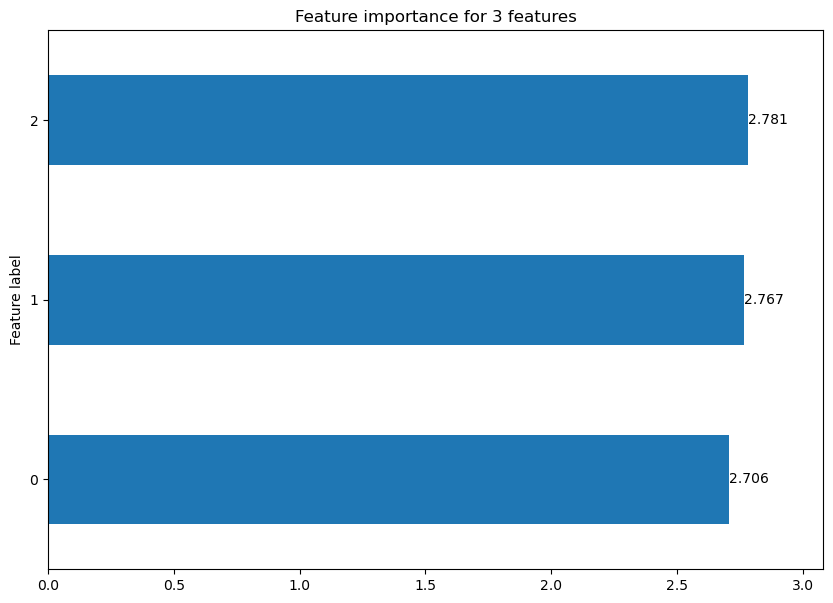

In [14]:
explanation.visualize_feature_importance(
)

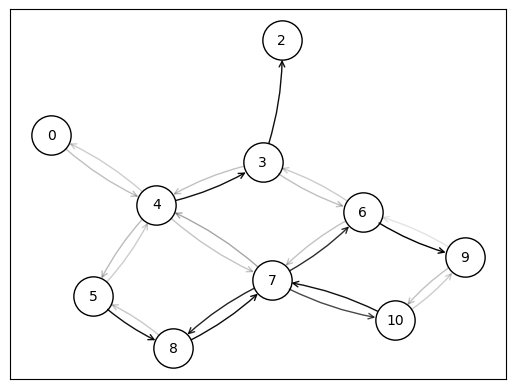

In [15]:
explanation.visualize_graph()

In [16]:
explanation.validate()

True

In [68]:
metric = unfaithfulness(explainer, explanation)
print(metric)

0.0


In [66]:
nodes = []
edges = []

for i in range(explanation.node_mask.shape[0]):
    node = {
        "id": str(i),
        'properties': {"label": str(i),}
    }
    nodes.append(node)
    
for j in range(explanation.edge_mask.shape[0]):
    edge = {
        "id": str(j),
        "start": str(explanation.edge_index[0, j].item()),
        "end": str(explanation.edge_index[1, j].item()),
        'properties': {'label': str(round(explanation.edge_mask[j].item(), 3))}
    }
    edges.append(edge)
    
def node_custom_size(index, node):
    size = 30
    size = size * (1+explanation.node_mask.mean(dim=1)[index].item())*1.5
    return size, size

def edge_custom_size(index, edge):
    size = 1
    size = size * (1+explanation.edge_mask[index].item())*1.5
    return size

cmap = plt.colormaps.get_cmap('viridis').colors
def edge_custom_color(index, edge):
    idx = int(explanation.edge_mask[index].item() * 255)
    int_color = [int(c*256) for c in cmap[idx]]
    return '#%02x%02x%02x' % (int_color[0], int_color[1], int_color[2])

In [67]:
w = GraphWidget()
w.nodes = nodes
w.edges = edges
w.directed = True
w.set_node_size_mapping(node_custom_size)
w.set_edge_thickness_factor_mapping(edge_custom_size)
w.set_edge_color_mapping(edge_custom_color)
display(w)

GraphWidget(layout=Layout(height='610px', width='100%'))